<a href="https://colab.research.google.com/github/raknampuna/csci-82_Fall2020/blob/master/HW2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Homework 2 CSCI E-82 2020
 
 Updated 9/18/2020


### Your name: ANUP MANKAR

In [ ]:
#imports

import os
import requests
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, layers, models, losses
import matplotlib.pyplot as plt

import zipfile
import numpy as np
import pandas as pd
import cv2
import time
from matplotlib import pyplot as plt
%matplotlib inline

from numpy import expand_dims
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

#### Due Friday October 2, 2020 11:59 pm EST
#### Show your work (i.e. code) and provide brief explanations where appropriate.  Include both your notebook file and a pdf file.  If you have leveraged any resources, be sure to include their citation where they are used

#### We do like to see your work and the outputs.  However, we don't need very chatty output since it makes it difficult to find your answer.  (We had a 100+ page submission for HW1 though we expected about 5 pages).

#### Note:  we want you to build your own networks throughout this homework.  This means defining each of the layers in the networks rather than use any pre-built classifiers that come with Keras.


We have created two different homework assignments for this assignment.  We will grade whatever you submit.  We also have a smaller data set and a larger data set. You might give a few extra points to your grade if you submit both. We also might give a few extra points if you do something else that is awesome.  

The intention is that if this is your first CNN, there is a lot of new concepts and ideas to get through.  If you've tried CNNs before as the majority have, we encourage you to try something more interesting.  If you are beginner, you can and should try both to maximize learning.  If you are already experienced in CNNs from your own work or other classes, you may submit the simpler version and avoid learning anything new.


In [ ]:
#### Download Data
def download_file(packet_url, base_path="", extract=False):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)

start_time = time.time()
download_file("https://anupfiles.s3.us-east-2.amazonaws.com/50x50.zip", base_path="datasets", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.17242887020111083


In [ ]:
#setting some global variables
epochs_val = 15

# <span style="color:blue">Problem Set for CNN novices</span>

#### The goal of this assignment is to classify 3 different types of images:  abstract, portraits and landscapes.  To standardize things, we have divided the data into training, validation and test sets.   Train on the training and assess whether you are overfitting based on the validation.  You can ignore the test set until the last problem where we ask you to make predictions on each image.  There is an information.txt file that has the labels.

In [ ]:
full_data=pd.read_csv('/content/datasets/50x50/truth.txt',sep='\t') 
full_data = full_data[full_data.Filename!='09686.jpg'] #dropping missing file
train = full_data[full_data['TrainValidateTest'] == 'train']
test = full_data[full_data['TrainValidateTest'] == 'test']
validate = full_data[full_data['TrainValidateTest'] == 'validate']
for dataset in [full_data,train,test,validate]:
  print(dataset.head(2),"\nNumber of rows: ",dataset.shape[0],"\n\n\n")

train_arr=np.asarray(train.iloc[:,[0,2]])
test_arr=np.asarray(test.iloc[:,[0,2]])
validate_arr=np.asarray(validate.iloc[:,[0,2]])

    Filename TrainValidateTest      Style            Genre            Artist
0  00000.jpg             train  landscape    Impressionism  Camille Pissarro
1  00001.jpg             train  landscape  Neo-Romanticism           Cookham 
Number of rows:  42873 



    Filename TrainValidateTest      Style            Genre            Artist
0  00000.jpg             train  landscape    Impressionism  Camille Pissarro
1  00001.jpg             train  landscape  Neo-Romanticism           Cookham 
Number of rows:  31991 



        Filename TrainValidateTest      Style               Genre        Artist
37992  38000.jpg              test   abstract        Outsider art  Forrest Bess
37993  38001.jpg              test  landscape  Post-Impressionism  Paul Cezanne 
Number of rows:  4882 



        Filename TrainValidateTest  ...         Genre                     Artist
31992  32000.jpg          validate  ...  Art Informel                   21 (NOR)
31993  32001.jpg          validate  ...     Symbolism

In [ ]:
lab_map = {'portrait':0, 'landscape':1, 'abstract':2,'self-portrait':0} #i included selfportrait in portraits here
train_path='/content/datasets/50x50/train'
valid_path='/content/datasets/50x50/validate'
test_path='/content/datasets/50x50/test'

#writing a quick function to check datasets for missing data
def check_data(path,array_data):
  for file in array_data[:,0]:
    if (os.path.exists(os.path.join(path,file)))==0:
                      print(file,"not available")
  print("done. errors (if any) above")



#function to format the data into images in an nd array
def format_data(data,path): 
  data_x = []
  data_y = []
  for file,label in data:
      # read image
      image = cv2.imread(os.path.join(path,file))
      # convert to rgb
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      # create and return datasets
      data_x.append(image)
      data_y.append(lab_map[label])
      
  data_x = np.asanyarray(data_x) / 255 #normalizing the data
  data_y = np.asanyarray(data_y) 
  # print(data_x.shape,data_y.shape) 
  return(data_x,data_y)

In [ ]:
train_x = [] #training image data
train_y = [] #training label data
validate_x = [] #validate image data
validate_y = [] #validate label data

train_x,train_y = format_data(train_arr,train_path)
validate_x,validate_y = format_data(validate_arr,valid_path)
test_x,test_y = format_data(test_arr,test_path)

In [ ]:
check_data(train_path,train_arr)
check_data(valid_path,validate_arr)
check_data(test_path,test_arr)


done. errors (if any) above
done. errors (if any) above
done. errors (if any) above


In [ ]:
print(train_x.shape)
print(train_y.shape)
print(validate_x.shape)
print(validate_y.shape)

(31991, 50, 50, 3)
(31991,)
(6000, 50, 50, 3)
(6000,)


In [ ]:
image_height, image_width, num_channels, num_classes = 50, 50, 3, 3

## Problem 1 Baseline Feedforward neural network classifier -- 10 points

### Use the training images to train up a feedforward classifer using the provided training.txt file which has the image names and labels.  

### Use the validation images to assess the performance of the classifier using the associated image names and labels.

### Create a plot of the training and validation results as a function of the epoch.  If you are using different metrics, be sure to put them on different plots.

In [ ]:
p1_modl = keras.Sequential([
    keras.layers.Flatten(input_shape = (50 , 50, 3))
    ,keras.layers.GaussianDropout(rate=.05)
    ,keras.layers.Dense(128, activation='relu')
    ,keras.layers.Dense(10)
    ,keras.layers.Dense(num_classes)
])

In [ ]:
p1_modl.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 7500)              0         
_________________________________________________________________
gaussian_dropout_4 (Gaussian (None, 7500)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               960128    
_________________________________________________________________
dense_40 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_41 (Dense)             (None, 3)                 33        
Total params: 961,451
Trainable params: 961,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.optimizers.SGD(lr=0.1)
p1_modl.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
results = p1_modl.fit(train_x, train_y, epochs=epochs_val, validation_data=(validate_x, validate_y))

Epoch 1/15
1000/1000 [==============================] - 7s 7ms/step - loss: 1.2812 - accuracy: 0.4075 - val_loss: 1.0686 - val_accuracy: 0.4283
Epoch 2/15
1000/1000 [==============================] - 7s 7ms/step - loss: 1.0763 - accuracy: 0.4146 - val_loss: 1.0658 - val_accuracy: 0.4285
Epoch 3/15
1000/1000 [==============================] - 7s 7ms/step - loss: 1.0720 - accuracy: 0.4163 - val_loss: 1.0655 - val_accuracy: 0.4283
Epoch 4/15
1000/1000 [==============================] - 7s 7ms/step - loss: 1.0710 - accuracy: 0.4220 - val_loss: 1.0696 - val_accuracy: 0.4282
Epoch 5/15
1000/1000 [==============================] - 7s 7ms/step - loss: 1.0698 - accuracy: 0.4214 - val_loss: 1.0721 - val_accuracy: 0.4285
Epoch 6/15
1000/1000 [==============================] - 7s 7ms/step - loss: 1.0691 - accuracy: 0.4203 - val_loss: 1.0654 - val_accuracy: 0.4285
Epoch 7/15
1000/1000 [==============================] - 7s 7ms/step - loss: 1.0689 - accuracy: 0.4228 - val_loss: 1.0776 - val_accuracy:

1000/1000 - 2s - loss: 1.0646 - accuracy: 0.4292


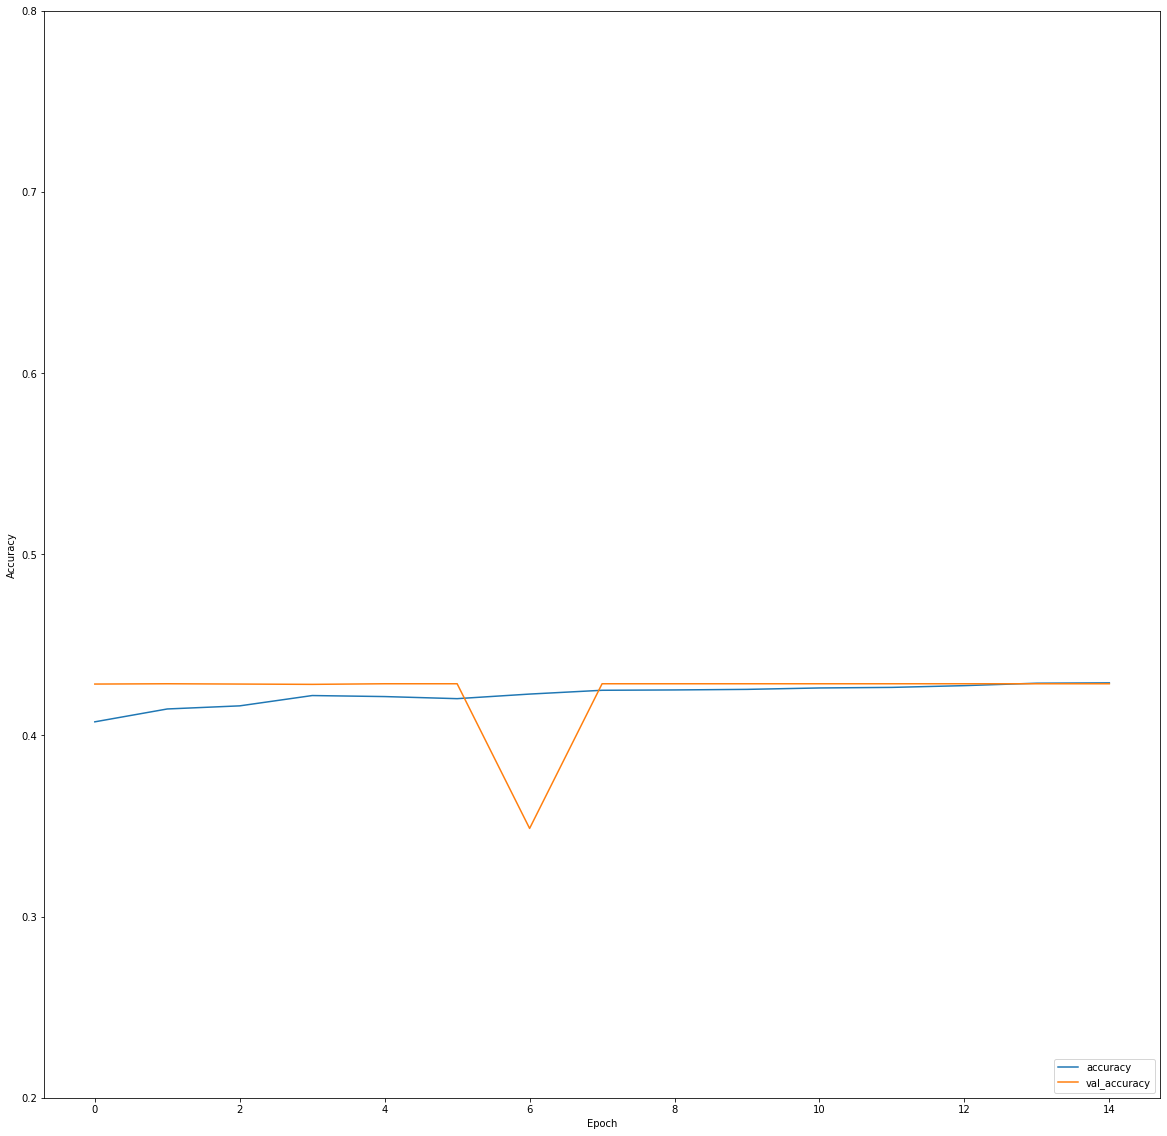

In [ ]:
plt.figure(figsize=(20, 20))

plt.plot(results.history['accuracy'], label='accuracy')
plt.plot(results.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, .8])
plt.legend(loc='lower right')


test_loss, test_acc =  p1_modl.evaluate(train_x,  train_y, verbose=2)

## Problem 2 Baseline CNN classifier -- 10 points

### Use the training images to train up a CNN classifer using the provided training.txt file which has the image names and labels.  

### Use the validation images to assess the performance of the classifier using the associated image names and labels.

### Create a plot of the training and validation results as a function of the epoch.


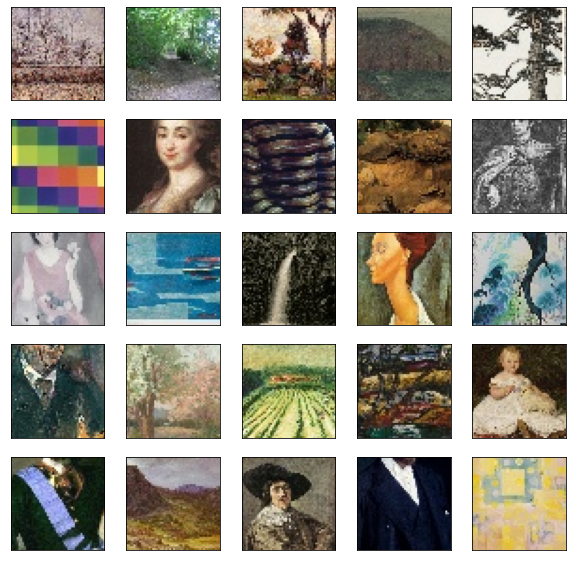

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_x[i], cmap=plt.cm.binary)
plt.show()

In [ ]:
#building my only model for problem 1:
def prob1_build_modl():
  modl = models.Sequential()
  modl.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)))
  modl.add(layers.MaxPooling2D((2, 2)))
  modl.add(layers.Conv2D(64, (3, 3), activation='relu'))
  modl.add(layers.MaxPooling2D((2, 2)))
  modl.add(layers.Conv2D(64, (3, 3), activation='relu'))
  modl.add(layers.Flatten())
  modl.add(layers.Dense(64, activation='relu'))
  modl.add(layers.Dense(10))
  modl.add(layers.Dense(num_classes))
  return(modl)
p2_modl = prob1_build_modl()
p2_modl.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 9, 9, 64)          36928     
_________________________________________________________________
flatten_15 (Flatten)         (None, 5184)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)              

In [ ]:
p2_modl.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
              # lss=tf.keras.losses.categorical_crossentropy
              ,metrics=['accuracy'])



In [ ]:
history = p2_modl.fit(train_x, train_y, epochs=epochs_val
                      ,validation_data=(validate_x, validate_y)
                    )

Epoch 1/15
1000/1000 [==============================] - 63s 63ms/step - loss: 0.6856 - accuracy: 0.7031 - val_loss: 0.5754 - val_accuracy: 0.7592
Epoch 2/15
1000/1000 [==============================] - 62s 62ms/step - loss: 0.5340 - accuracy: 0.7775 - val_loss: 0.5612 - val_accuracy: 0.7685
Epoch 3/15
1000/1000 [==============================] - 62s 62ms/step - loss: 0.4808 - accuracy: 0.8037 - val_loss: 0.5161 - val_accuracy: 0.7888
Epoch 4/15
1000/1000 [==============================] - 62s 62ms/step - loss: 0.4397 - accuracy: 0.8209 - val_loss: 0.5207 - val_accuracy: 0.7962
Epoch 5/15
1000/1000 [==============================] - 64s 64ms/step - loss: 0.3955 - accuracy: 0.8427 - val_loss: 0.4981 - val_accuracy: 0.8045
Epoch 6/15
1000/1000 [==============================] - 66s 66ms/step - loss: 0.3544 - accuracy: 0.8582 - val_loss: 0.5633 - val_accuracy: 0.7907
Epoch 7/15
1000/1000 [==============================] - 67s 67ms/step - loss: 0.3051 - accuracy: 0.8794 - val_loss: 0.5774 -

188/188 - 3s - loss: 1.2708 - accuracy: 0.7905
1.2708393335342407 0.7904999852180481


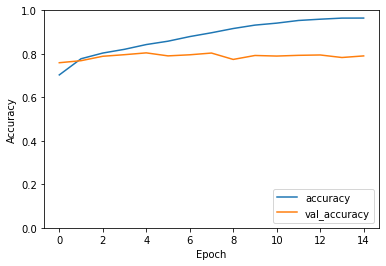

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0., 1])
plt.legend(loc='lower right')
valid_loss, valid_acc = p2_modl.evaluate(validate_x,  validate_y, verbose=2)
print(valid_loss, valid_acc)

## Problem 3  Improved CNN classifier -- 15 points

### Chose a single parameter with at least 3 different values.  The parameters can include the number or size of the convolutional kernels, the number/size of the layers.  Report the performance as a function of epoch. 

In [ ]:
#function to build models in problem3:
def prob3_build_modl(k_size=3):
  modl = models.Sequential()
  modl.add(layers.Conv2D(filters = 32, kernel_size = k_size, strides = (3, 3), activation='relu', input_shape=(50, 50, 3)))
  modl.add(layers.MaxPooling2D((2, 2)))
  modl.add(layers.Conv2D(64, (3, 3), activation='relu'))
  modl.add(layers.MaxPooling2D((2, 2)))
  modl.add(layers.Conv2D(64, (3, 3), activation='relu'))
  modl.add(layers.Flatten())
  modl.add(layers.Dense(64, activation='relu'))
  modl.add(layers.Dense(10))
  modl.add(layers.Dense(num_classes))
  return(modl)

#function to compile and fit model
def prob3_compile(modl,epchs = epochs_val):
  modl.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
              ,metrics=['accuracy'])
  return(modl)
  
def prob3_fit(modl,epchs = epochs_val):
  hist = modl.fit(train_x, train_y
                     ,epochs=epchs
                     ,validation_data=(validate_x, validate_y))
  return(hist)
  

#function to print results / chart
def print_history(modl,hist):
  plt.plot(hist.history['accuracy'], label='accuracy')
  plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0., 1])
  plt.legend(loc='lower right')
  valid_loss, valid_acc = modl.evaluate(validate_x,  validate_y, verbose=2)
  print(valid_loss, valid_acc)
  

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 16, 16, 32)        896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten_16 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 64)              

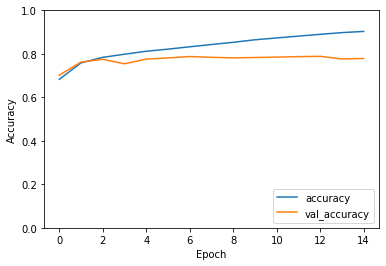

In [ ]:
k = 3

p3_1modl = prob3_build_modl(k_size = k)
print(p3_1modl.summary())
p3_1modl= prob3_compile(p3_1modl)
history=prob3_fit(p3_1modl,epochs_val)
print_history(p3_1modl,history)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 16, 16, 32)        1568      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten_17 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 64)              

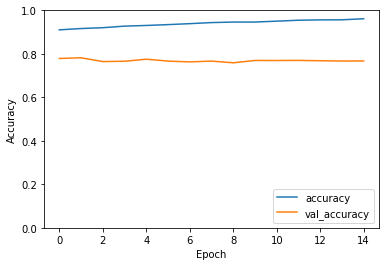

In [ ]:
k = 4

p3_2modl = prob3_build_modl(k_size = k)
print(p3_2modl.summary())
p3_2modl= prob3_compile(p3_1modl)
history=prob3_fit(p3_2modl,epochs_val)
print_history(p3_2modl,history)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 16, 16, 32)        2432      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten_18 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 64)              

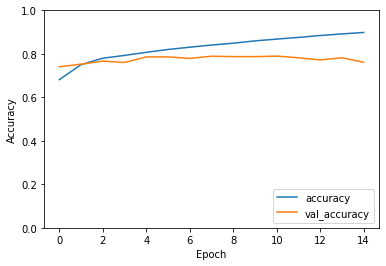

In [ ]:
k = 5

p3_3modl = prob3_build_modl(k_size = k)
print(p3_3modl.summary())
p3_1modl= prob3_compile(p3_3modl)
history=prob3_fit(p3_1modl,epochs_val)
print_history(p3_3modl,history)

## Problem 4  Further improved CNN classifier -- 15 points

### Use the best parameter found in Problem 3.  Choose a second paramter from the same list to optimize in the same way with at least 3 different values.  Cre|ate a plot of the training and validation results as a function of the epoch.

In [ ]:
#first function to build models in problem4:
def prob4_build_modl(k_size=5):
  modl = models.Sequential()
  modl.add(layers.Conv2D(filters = 32, kernel_size = k_size, strides = (3, 3), activation='relu', input_shape=(50, 50, 3)))
  modl.add(layers.MaxPooling2D((2, 2)))
  modl.add(layers.Conv2D(64, (3, 3), activation='relu'))
  modl.add(layers.MaxPooling2D((2, 2)))
  modl.add(layers.Conv2D(64, (3, 3), activation='relu'))
  modl.add(layers.Flatten())
  modl.add(layers.Dense(64, activation='relu'))
  modl.add(layers.Dense(10))
  modl.add(layers.Dense(10))
  modl.add(layers.Dense(num_classes))
  return(modl)

#functions to compile and fit model
def prob4_compile(modl,epchs = epochs_val):
  modl.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
              ,metrics=['accuracy'])
  return(modl)
  
def prob4_fit(modl,epchs = epochs_val):
  hist = modl.fit(train_x, train_y
                     ,epochs=epchs
                     ,validation_data=(validate_x, validate_y))
  return(hist)
  

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 16, 16, 32)        2432      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten_19 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 64)              

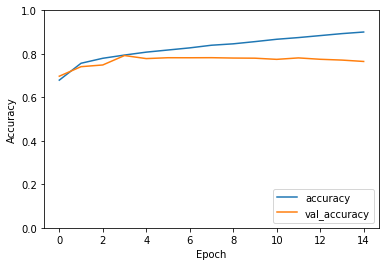

In [ ]:
p4_1modl = prob4_build_modl()
print(p4_1modl.summary())
p4_1modl= prob3_compile(p4_1modl)
history=prob3_fit(p4_1modl,epochs_val)
print_history(p4_1modl,history)

In [ ]:
#first function to build models in problem4:
def prob4_build_modl_2(k_size=5):
  modl = models.Sequential()
  modl.add(layers.Conv2D(filters = 32, kernel_size = k_size, strides = (3, 3), activation='relu', input_shape=(50, 50, 3)))
  modl.add(layers.MaxPooling2D((2, 2)))
  modl.add(layers.Conv2D(64, (3, 3), activation='relu'))
  modl.add(layers.MaxPooling2D((2, 2)))
  modl.add(layers.Conv2D(64, (3, 3), activation='relu'))
  modl.add(layers.Flatten())
  modl.add(layers.Dense(64, activation='relu'))
  modl.add(layers.Dense(10))
  modl.add(layers.Dense(10))
  modl.add(layers.Dense(20))
  modl.add(layers.Dense(num_classes))
  return(modl)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 16, 16, 32)        2432      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten_23 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 64)              

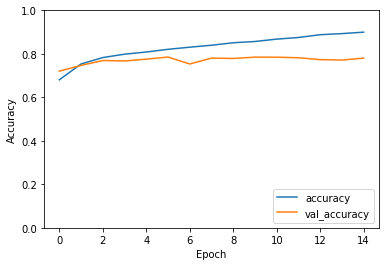

In [ ]:
p4_1modl = prob4_build_modl_2()
print(p4_1modl.summary())
p4_1modl= prob3_compile(p4_1modl)
history=prob3_fit(p4_1modl,epochs_val)
print_history(p4_1modl,history)

In [ ]:
#first function to build models in problem4:
def prob4_build_modl_3(k_size=5):
  modl = models.Sequential()
  modl.add(layers.Conv2D(filters = 32, kernel_size = k_size, strides = (3, 3), activation='relu', input_shape=(50, 50, 3)))
  modl.add(layers.MaxPooling2D((2, 2)))
  modl.add(layers.Conv2D(64, (3, 3), activation='relu'))
  modl.add(layers.MaxPooling2D((2, 2)))
  modl.add(layers.Conv2D(64, (3, 3), activation='relu'))
  modl.add(layers.Flatten())
  modl.add(layers.Dense(64, activation='relu'))
  modl.add(layers.Dense(10))
  modl.add(layers.Dense(10))
  modl.add(layers.Dense(20))
  modl.add(layers.Dense(100))
  modl.add(layers.Dense(num_classes))
  return(modl)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 16, 16, 32)        2432      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten_24 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_74 (Dense)             (None, 64)              

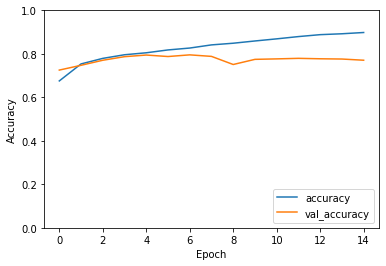

In [ ]:
p4_1modl = prob4_build_modl_2()
print(p4_1modl.summary())
p4_1modl= prob3_compile(p4_1modl)
history=prob3_fit(p4_1modl,epochs_val)
print_history(p4_1modl,history)

## Problem 5 Optimized CNN classifier -- 20 points

### Further optimize the classifier to achieve the best results that you can.   Create a plot of the training and validation results as a function of the epoch.

As you can see from all the previous visualizations, there seems to be a bit of overfitting. To address this I will try to update my model with some dropout between the dense layers at the end.  Other than the dropout layers, for now I'll keep everything else the same as the last set of models.   

In [ ]:
#function to build models in problem5:
def prob5_build_modl(k_size=5):
  modl = models.Sequential()
  modl.add(layers.Conv2D(filters = 32, kernel_size = k_size, strides = (3, 3), activation='relu', input_shape=(50, 50, 3)))
  modl.add(layers.MaxPooling2D((2, 2)))
  modl.add(layers.Conv2D(64, (3, 3), activation='relu'))
  modl.add(layers.MaxPooling2D((2, 2)))
  modl.add(layers.Conv2D(64, (3, 3), activation='relu'))
  modl.add(layers.Flatten())
  modl.add(layers.Dense(64, activation="relu"))
  modl.add(layers.Dropout(0.7))
  modl.add(layers.Dense(128, activation="relu"))
  modl.add(layers.Dropout(0.5))
  modl.add(layers.Dense(10, activation="relu"))
  modl.add(layers.Dropout(0.2))
  modl.add(layers.Dense(num_classes))
  return(modl)



Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 16, 16, 32)        2432      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten_28 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_91 (Dense)             (None, 64)              

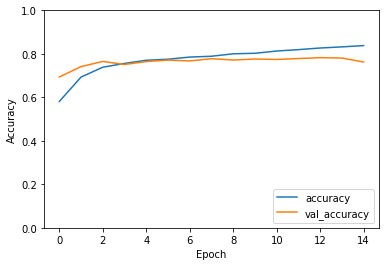

In [ ]:
p5_modl = prob5_build_modl()
print(p5_modl.summary())
p5_modl= prob4_compile(p5_modl)
history=prob4_fit(p5_modl,epochs_val)
print_history(p5_modl,history)

As you can see with these drop out layers the gap between the accuracies does seem to decrease.  I'm going to run the model one more time with less epochs, = 5, to see what kind of results i can get. 

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 16, 16, 32)        2432      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten_29 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_95 (Dense)             (None, 64)              

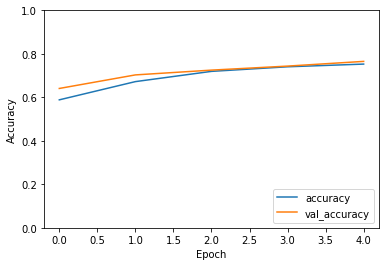

In [ ]:
p5_modl = prob5_build_modl()
print(p5_modl.summary())
p5_modl= prob4_compile(p5_modl)
history=prob4_fit(p5_modl,5)
print_history(p5_modl,history)

As you can see there seems to be less divergence between the validate data set and the training data set, indicating lack over overfitting.  Additionally I'm seeing that the loss decreased over each epoch and didn't change much since the last model.  I'll stick with this one.

## Problem 6  Final predictions -- 15 points

### Perform a classification on the test images with your optimized classifier.  This is the first time you should be using the test folder.  Compute the prediction accuracy through a confusion matrix (True Positive, True Negative, False Positive, False Negative) and overall accuracy which is the fraction of (True Positive + True Negative).  

In [ ]:
predictions = p5_modl.predict(test_x)
scores = tf.nn.softmax(predictions)
scores = np.argmax(scores, axis=1)
scores

array([0, 1, 2, ..., 1, 0, 0])

In [ ]:
conf_matrix = tf.math.confusion_matrix(
    test_y
    ,scores
    ,num_classes=num_classes
    ,dtype=tf.dtypes.int32
)
conf_matrix

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[1766,  105,  200],
       [ 198, 1383,  166],
       [ 269,  152,  643]], dtype=int32)>

In [ ]:
true_pos = np.sum(np.diagonal(conf_matrix))
total_obs = np.sum(conf_matrix)

In [ ]:
accuracy = true_pos/total_obs
accuracy

0.7767308480131094

In [ ]:
#just to double check, i'll use an sklearn package
accuracy_score(test_y,scores)

0.7767308480131094

## Problem 7  -- 5 points

### How long did this homework take?

Probably 8-10 hours, but that involves a lot of research and going to lecture, etc. 

## Problem 8 -- 5 points

### Create a pdf of this notebook and submit the pdf file and this notebook.

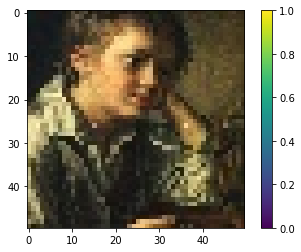

In [ ]:
plt.figure()
plt.imshow(train_x[48])
plt.colorbar()
plt.grid(False)
plt.show()

# <span style="color:blue">Problem Set for those with CNN experience</span>

#### The goal of this assignment is to determine how many classes there really are in the same image set.  Sure, there are portraits, abstract art and landscapes, but art is more than these labels.  There are styles, eras, artistic freedom, emotions, colors.  

#### This assignment is designed to use an CNN-based autoencoder.  There are various flavors including denoising autoencoder, variational autoencoder and others.  The simplest is just the denoising autoencoder with the inputs and outputs set equal to each other.  The center layer should likely have a smaller dimensionality than the original so it can be viewed perhaps with a UMAP.



## Problem A Baseline CNN autoencoder -- 25 points

### Use the training images to train up a CNN classifer using the provided training.txt file which has the image names and labels.  Even though it's an unsupervised or self-supervised training, you will still want to use the validation set to avoid over-training.  

### Plot the results as a function of epoch for the training and validation sets.  If you are using different metrics, be use to put them on separate plots.


### Problem B  Optimize your CNN autoencoder -- 25 points

### We want to see several different factors being adjusted to come up with a better result along with an interpretation of what and why.  Ideally, this will discuss if and where there may be an overfit or underfit and how you attempted to remedy it.

## Problem C Adjust the middle layer size -- 15 points

### Try at least 2 substantially different sizes of the middle layer.   Provide an your interpretation of the results.

## Problem D  Write out the middle layer results -- 5 points

### Create a file of your choosing that contains the middle layer for at least the training set (and possibly the validation set if you wish.  It can be any flavor of file you wish (text, panda, etc).
 

## Problem E  Explain the autoencoder's interpretation of art. -- 20 points

### Create a UMAP plots of the training data points.  Color the points based on information in the information.txt file using different criteria.  That is, make different plots with the same x-y points obtained from the UMAP, but color them differently based on style, genre, or anything else.  Explain what you found.


## Problem F  -- 5 points

### How long did this homework take?

## Problem G -- 5 points

### Create a pdf of this notebook and submit the pdf file and this notebook.